Fourth figure of the manuscript, showing Cross-correlation analyses. 
- Fitting results
- brain maps
- correlations of spatial parameter b with timescales for LFP and gamma

In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import zscore, bootstrap, ttest_rel, false_discovery_control
import matplotlib.pyplot as plt
import mne
import nilearn
from nilearn import surface as nisurf

import mni_utils as uti
from mni_plots import (
    plot_parcellated_metric,
    half_violin_plot,
    plot_corr,
    slope_plot,
    plot_sc_fit,
    plot_hip_amy,
    _reset_default_rc,
    _set_font_params,
    fsize,
    save_figure,
    _get_figsize_inches,
    _get_correct_font_size,
)

Paths and names:

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
lfp_path = data_path.joinpath("Results_SC")
gamma_path = data_path.joinpath("Results_SC_gamma")
tau_path = data_path.joinpath("Results_acf_fit_exp")
tau_gamma_path = data_path.joinpath("Results_gamma")
fig_path = data_path.joinpath("Figures")

Destrieux Parcellation:

In [63]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "aparc.a2009s"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)

Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.aparc.a2009s.annot


MNIA - Destrieux mapping:

In [5]:
df_mnia_dest = pd.read_excel(
    data_path.joinpath("mnia_Destrieux_labels.xlsx"), index_col=0
)
df_mnia_dest["Destrieux atlas name"] = df_mnia_dest["Destrieux atlas name"].str.strip(
    "'"
)
df_mnia_dest.rename(
    columns={
        "Destrieux atlas name": "Destrieux",
        "MNIA equivalent": "MNIA",
    },
    inplace=True,
)
df_mnia_dest.drop(columns="Expanded name", inplace=True)

Hippocampus and Amygdala surface:

In [6]:
surface_hip_amy = nisurf.load_surf_mesh(data_path.joinpath("surfaces/Hip_Amy.surf.gii"))
surface_hip_amy = uti.project_hemis_surf(surface_hip_amy, hemis="left")

Harvard-Oxford dataset for subcortical structures:

In [7]:
HO_atlas = nilearn.datasets.fetch_atlas_harvard_oxford(
    "sub-maxprob-thr50-1mm", symmetric_split=False
)

SC results and parameters:

In [8]:
# LFP results
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Gamma results
# Dataframe with data on all channles pairs
df_sc_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

Timescales:

In [9]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(tau_path.joinpath("all_tau.csv"), index_col=0)
df_tau_gamma = pd.read_csv(tau_gamma_path.joinpath("all_tau.csv"), index_col=0)

### A) Plot Correlation vs distance plots 

LFP:

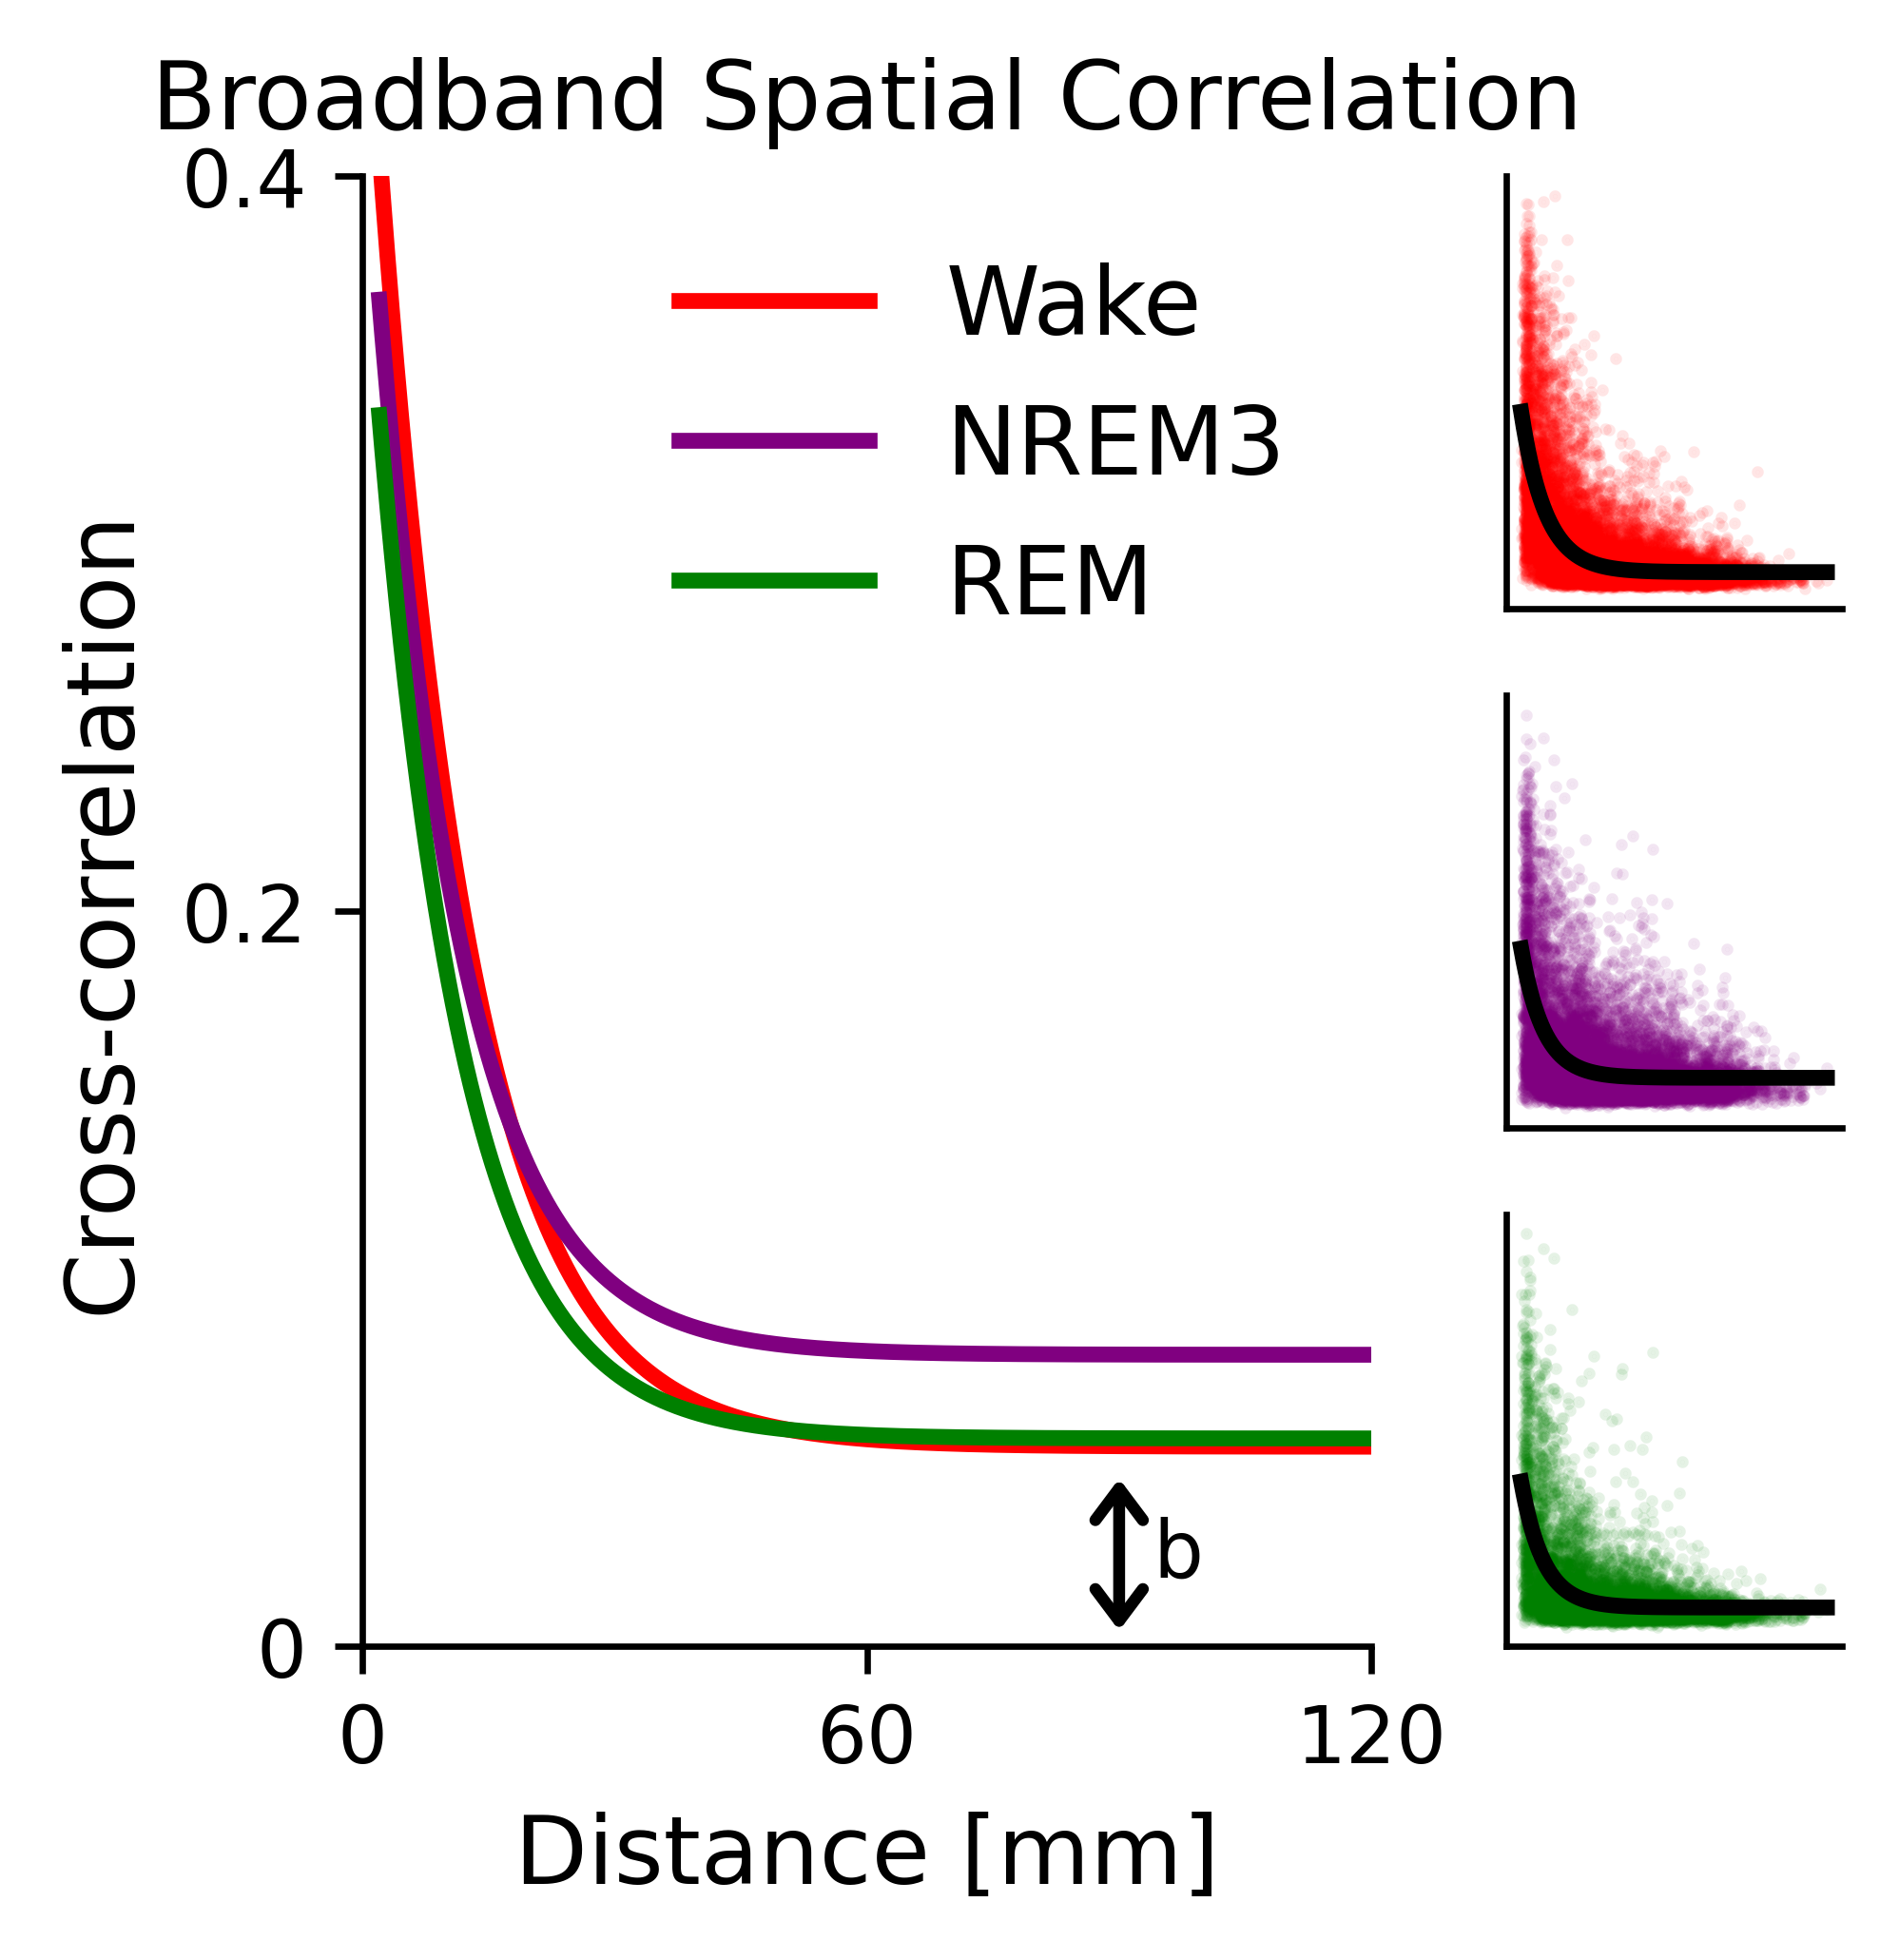

In [84]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}


params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages.items()
}



fig, axs = plot_sc_fit(
    df_sc_stages,
    params_stages,
    colors_stage,
    dict_stages=title_dict,
    figsize=(8.5, 8.5),
)

# Adjust plot
axs[0].set_xlim(0, 120)
axs[0].set_ylim(0, 0.4)
axs[0].set_xticks([0, 60, 120], labels=[0, 60, 120], fontsize=fsize.TICK_SIZE)
axs[0].set_yticks([0, 0.2, 0.4], labels=[0, 0.2, 0.4], fontsize=fsize.TICK_SIZE)
axs[0].set_title("Broadband Spatial Correlation", fontsize=fsize.TITLE_SIZE)
# Annotate b parameter
axs[0].annotate(
    "",
    xy=(90, 0.05),
    xytext=(90, 0),
    arrowprops=dict(arrowstyle="<->, head_width=0.3", linewidth=1.5),
)
axs[0].annotate("b", xy=(94, 0.025), va="center", fontsize=fsize.TEXT_SIZE)

# Save figure to svg
save_figure(fig, fig_path.joinpath("Fig_3", "Fig_3_fit_stages.svg"))



plt.show()

Gamma:

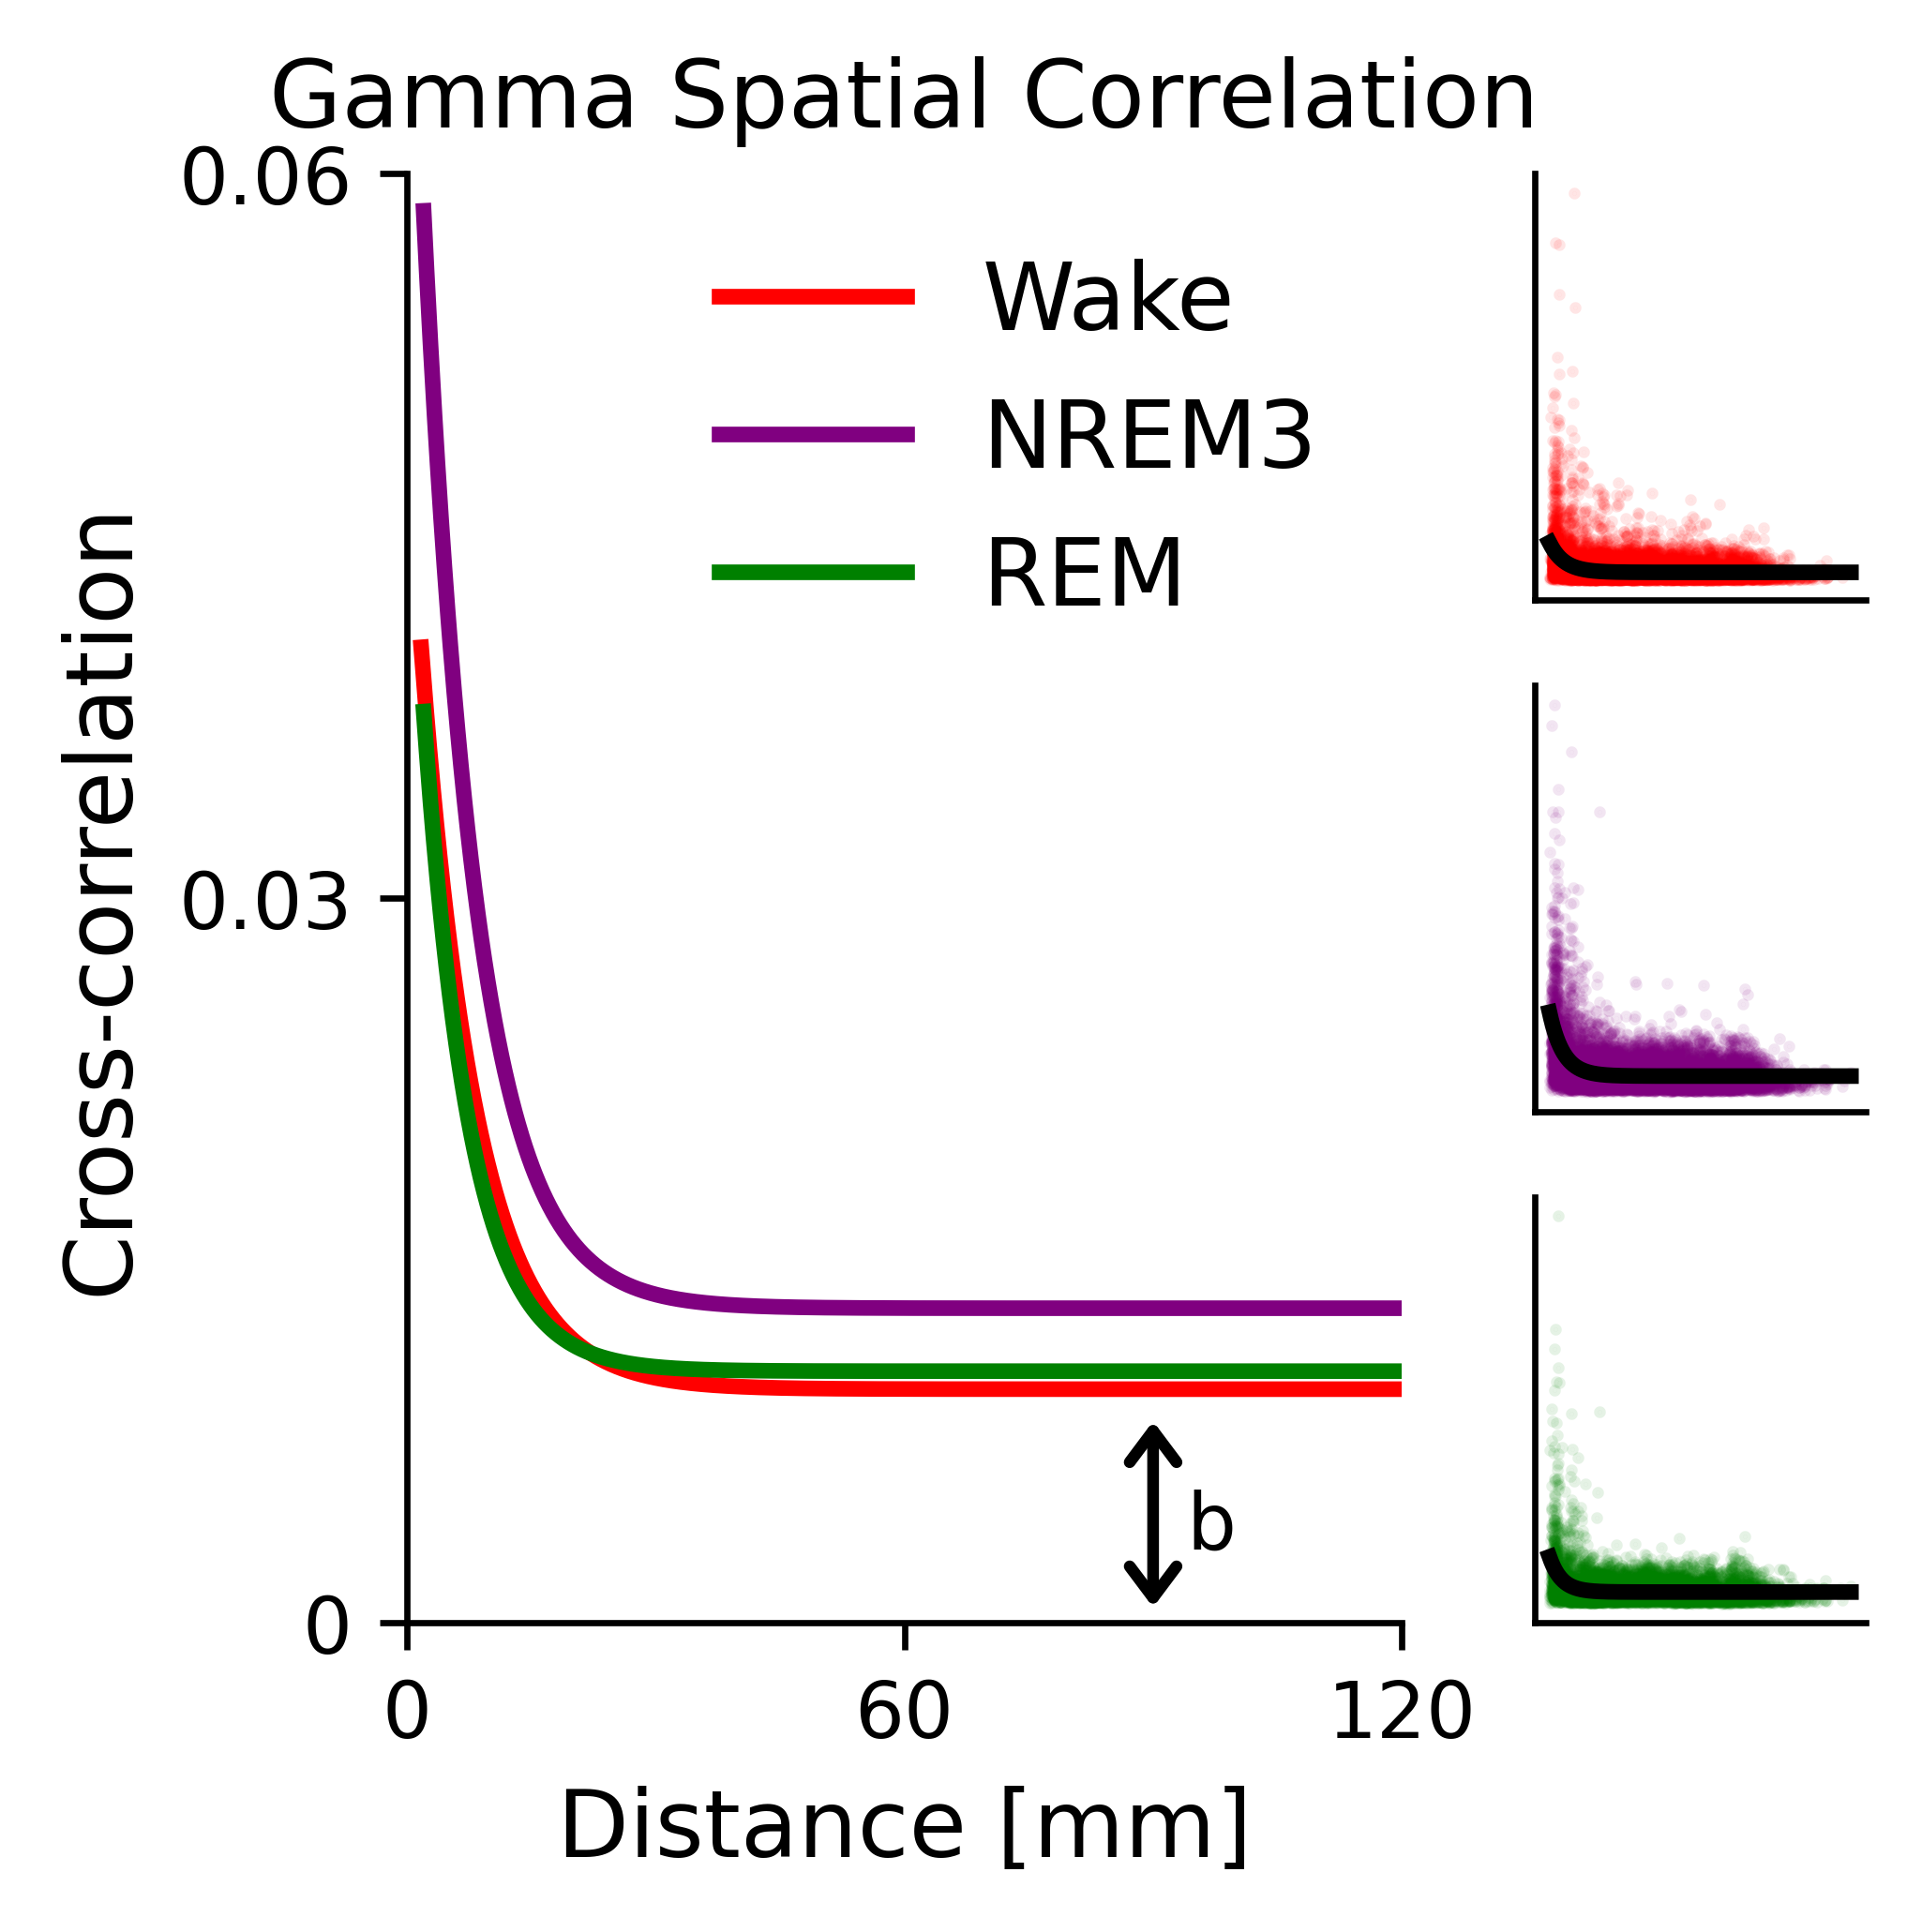

In [85]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages_gamma.items()
}

fig, axs = plot_sc_fit(
    df_sc_stages_gamma,
    params_stages,
    colors_stage,
    dict_stages=title_dict,
    figsize=(8.5, 8.5),
)

# Adjust plot
axs[0].set_xlim(0, 120)
axs[0].set_ylim(0, 0.06)
axs[0].set_xticks([0, 60, 120], labels=[0, 60, 120], fontsize=fsize.TICK_SIZE)
axs[0].set_yticks([0, 0.03, 0.06], labels=[0, 0.03, 0.06], fontsize=fsize.TICK_SIZE)
axs[0].set_title("Gamma Spatial Correlation", fontsize=fsize.TITLE_SIZE)
# Annotate b parameter
axs[0].annotate(
    "",
    xy=(90, 0.009),
    xytext=(90, 0),
    arrowprops=dict(arrowstyle="<->, head_width=0.3", linewidth=1.5),
)
axs[0].annotate("b", xy=(94, 0.004), va="center", fontsize=fsize.TEXT_SIZE)

# Save figure to svg
save_figure(fig, fig_path.joinpath("Fig_3", "Fig_3_fit_stages_gamma.svg"))

plt.show()

### B) Brain map of b parameter

LFP:

In [42]:
data_plot = {}

# Prepare data for plotting
for stage in ["W", "N3", "R"]:

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages[stage].copy()

    # Convert to Destrieux regions
    df_stage_dest = df_mnia_dest.copy()
    df_stage_dest.dropna(inplace=True)
    df_stage_dest["b"] = df_stage_mni.loc[
        df_stage_dest["MNIA"].to_list(), "b"
    ].to_list()
    df_stage_dest = df_stage_dest[["Destrieux", "b"]].groupby("Destrieux").mean()

    # Create parcellation on cortex
    N_vert = max([max(label.vertices) for label in labels_mne])
    dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
    parc_names = [label.name[:-3] for label in labels_mne]
    for i, (name, label) in enumerate(zip(parc_names, labels_mne)):
        if name in df_stage_dest.index:
            dest_plot_parc[label.vertices] = i + 1

    # Select data for plot and limits
    data_plot[stage] = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()

In [68]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
lims_plot = {"W": [0.03, 0.07], "N3": [0.045, 0.095], "R": [0.035, 0.065]}

for stage in ["W", "N3", "R"]:


    # Plot on cortex

    fig, ax = plot_parcellated_metric(
        data_plot[stage],
        dest_plot_parc,

        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=lims_plot[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="b parameter fit [a.u.]",
        cbar_format="3f",

    )
    fig.savefig(
        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_ctx.svg"), format="svg"
    )

    plt.close(fig)


    # Plot on hippocampus and amygdala

    surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)

    val_amy = df_stage_mni.loc["Amygdala", "b"]

    val_hip = df_stage_mni.loc["Hippocampus", "b"]

    fig = plot_hip_amy(
        surface_hip_amy, val_hip, val_amy, surface_nodes_labels, lims_plot[stage]
    )

    fig.write_image(

        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_hipamy.svg"),
        format="svg",
    )

Gamma:

In [69]:
data_plot = {}

# Prepare data for plotting
for stage in ["W", "N3", "R"]:

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages_gamma[stage].copy()

    # Convert to Destrieux regions
    df_stage_dest = df_mnia_dest.copy()
    df_stage_dest.dropna(inplace=True)
    df_stage_dest["b"] = df_stage_mni.loc[
        df_stage_dest["MNIA"].to_list(), "b"
    ].to_list()
    df_stage_dest = df_stage_dest[["Destrieux", "b"]].groupby("Destrieux").mean()

    # Create parcellation on cortex
    N_vert = max([max(label.vertices) for label in labels_mne])
    dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
    parc_names = [label.name[:-3] for label in labels_mne]
    for i, (name, label) in enumerate(zip(parc_names, labels_mne)):
        if name in df_stage_dest.index:
            dest_plot_parc[label.vertices] = i + 1

    # Select data for plot and limits
    data_plot[stage] = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()

In [73]:
np.quantile(data_plot["R"], [0.025, 0.975])

array([0.00420681, 0.01612706])

In [74]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
lims_plot = {"W": [0.0055, 0.015], "N3": [0.0067, 0.016], "R": [0.004, 0.016]}

for stage in ["W", "N3", "R"]:

    # Plot on cortex
    fig, ax = plot_parcellated_metric(
        data_plot[stage],
        dest_plot_parc,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=lims_plot[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="b parameter fit [a.u.]",
        cbar_format="3f",
    )
    fig.savefig(
        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_ctx_gamma.svg"),
        format="svg",
    )

    plt.close(fig)

    # Plot on hippocampus and amygdala
    surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
    val_amy = df_stage_mni.loc["Amygdala", "b"]
    val_hip = df_stage_mni.loc["Hippocampus", "b"]
    fig = plot_hip_amy(
        surface_hip_amy, val_hip, val_amy, surface_nodes_labels, lims_plot[stage]
    )
    fig.write_image(
        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_hipamy_gamma.svg"),
        format="svg",
    )

### C) Average increase of during sleep

LFP:

In [ ]:
# Add stage to the dataframe
df_metric = deepcopy(df_sc_params_mni_stages)
df_metric["W"]["stage"] = "W"
df_metric["N3"]["stage"] = "N3"
df_metric["R"]["stage"] = "R"
df_metric = pd.concat(df_metric.values())
df_metric = df_metric.pivot(columns="stage", values="b")
df_metric["ID"] = np.arange(len(df_metric.index))

diff W - N3 : 0.02120593369149785 4.408705759074865e-11
diff W - R : 0.00036668838433413694 0.8681461398394723


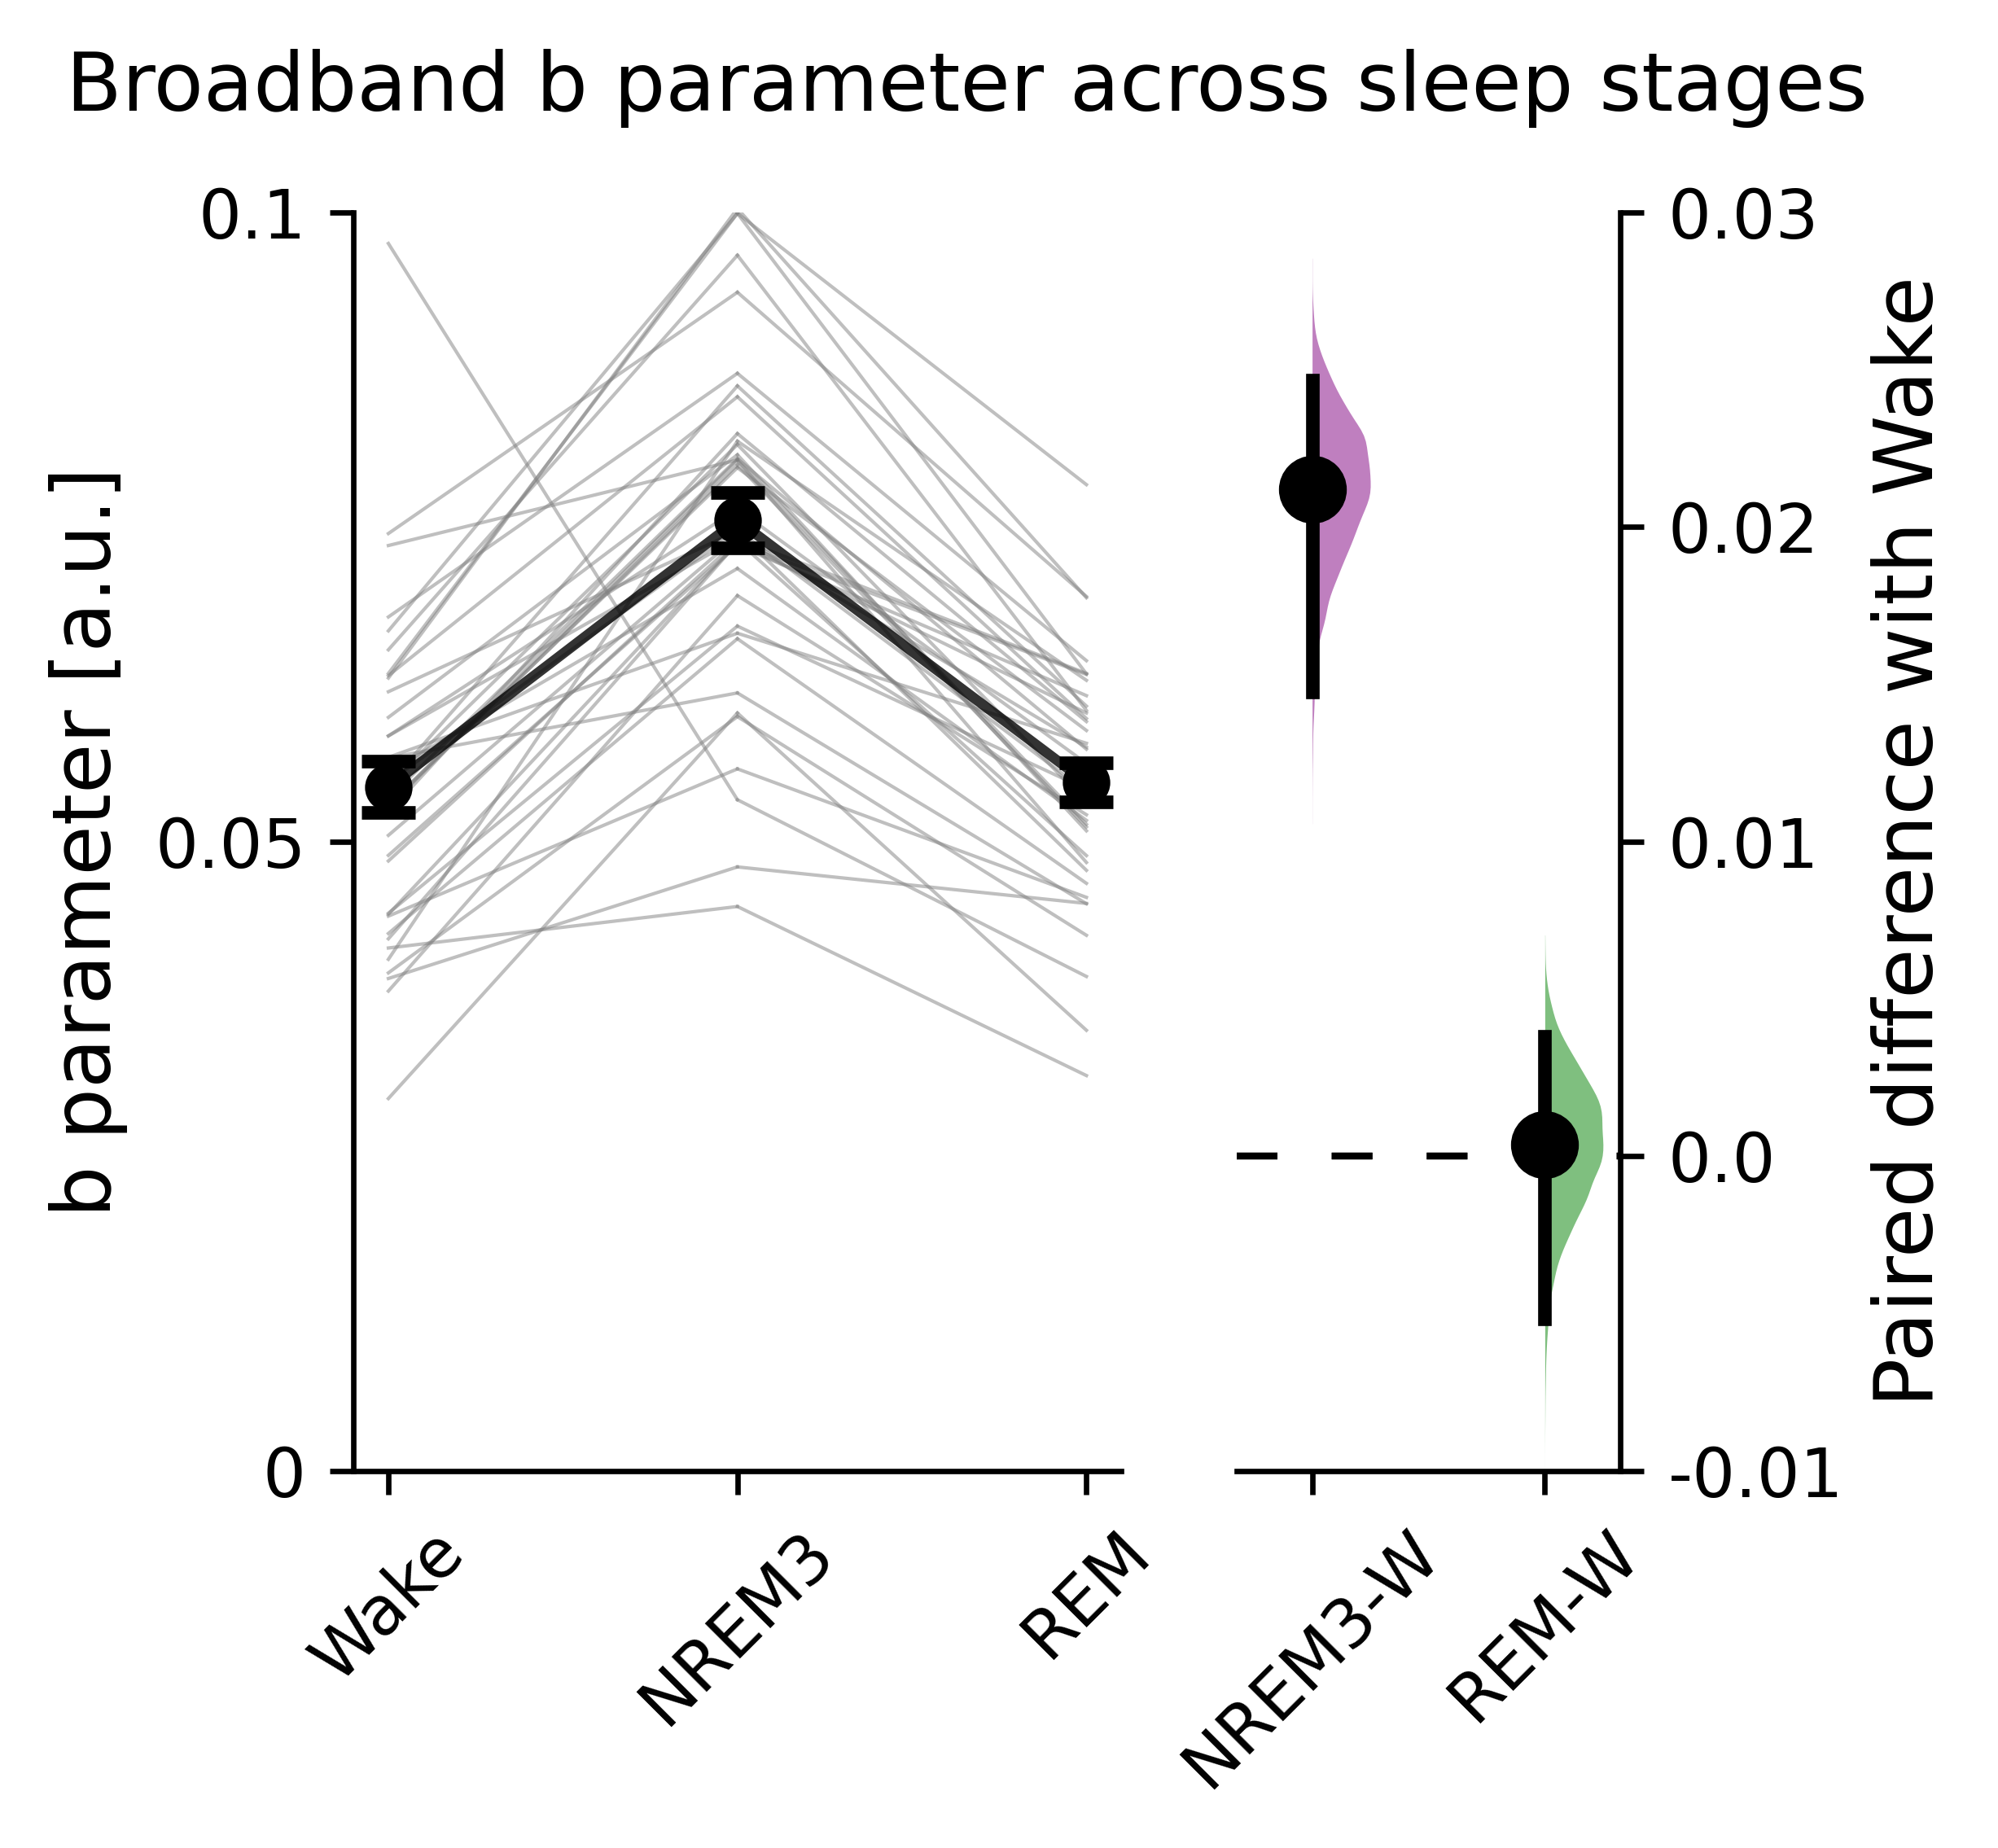

In [95]:
# Define colors for stages
stage_colors = {"W": "red", "N3": "purple", "R": "green"}

# Figure
fig, axs = plt.subplots(
    1, 2, figsize=_get_figsize_inches((8.5, 8.5)), width_ratios=[2, 1], dpi=600
)

# Slope plot
df_metric_plot = df_metric[["W", "N3", "R"]].copy()
axs[0] = slope_plot(axs[0], df_metric_plot)
# Plot parameters
axs[0].set_ylabel("b parameter [a.u.]", fontsize=fsize.LABEL_SIZE)
axs[0].set_ylim(0.0, 0.1)
axs[0].set_yticks([0, 0.05, 0.1], labels=[0, 0.05, 0.1], fontsize=fsize.TICK_SIZE)
axs[0].set_xticks(
    [0, 1, 2],
    ["Wake", "NREM3", "REM"],
    rotation=45,
    ha="center",
    fontsize=fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)
# Plot differences
for i, stage in enumerate(["N3", "R"]):
    avg = avg_diff(df_metric_plot[stage], df_metric_plot["W"])
    pval = ttest_rel(df_metric_plot[stage], df_metric_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_metric_plot[stage], df_metric_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )

    axs[1] = half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(-0.01, 0.03)
axs[1].set_yticks(
    [-0.01, 0.0, 0.01, 0.02, 0.03],
    labels=[-0.01, 0.0, 0.01, 0.02, 0.03],
    fontsize=fsize.TICK_SIZE,
)
axs[1].set_xticks(
    [0, 1], ["NREM3-W", "REM-W"], rotation=45, fontsize=fsize.TICK_SIZE
)
axs[1].spines[["top", "left"]].set_visible(False)
fig.suptitle(f"Broadband b parameter across sleep stages", fontsize=fsize.TITLE_SIZE)

# Save figure
save_figure(fig, fig_path.joinpath("Fig_3", f"Fig3_b_change_stages.svg"))
plt.show()

Gamma:

In [97]:
# Add stage to the dataframe
df_metric = deepcopy(df_sc_params_mni_stages_gamma)
df_metric["W"]["stage"] = "W"
df_metric["N3"]["stage"] = "N3"
df_metric["R"]["stage"] = "R"
df_metric = pd.concat(df_metric.values())
df_metric = df_metric.pivot(columns="stage", values="b")
df_metric["ID"] = np.arange(len(df_metric.index))

diff W - N3 : 0.0035939997060791505 2.993446389397578e-11
diff W - R : 0.0011297553695299657 0.02230922533439648


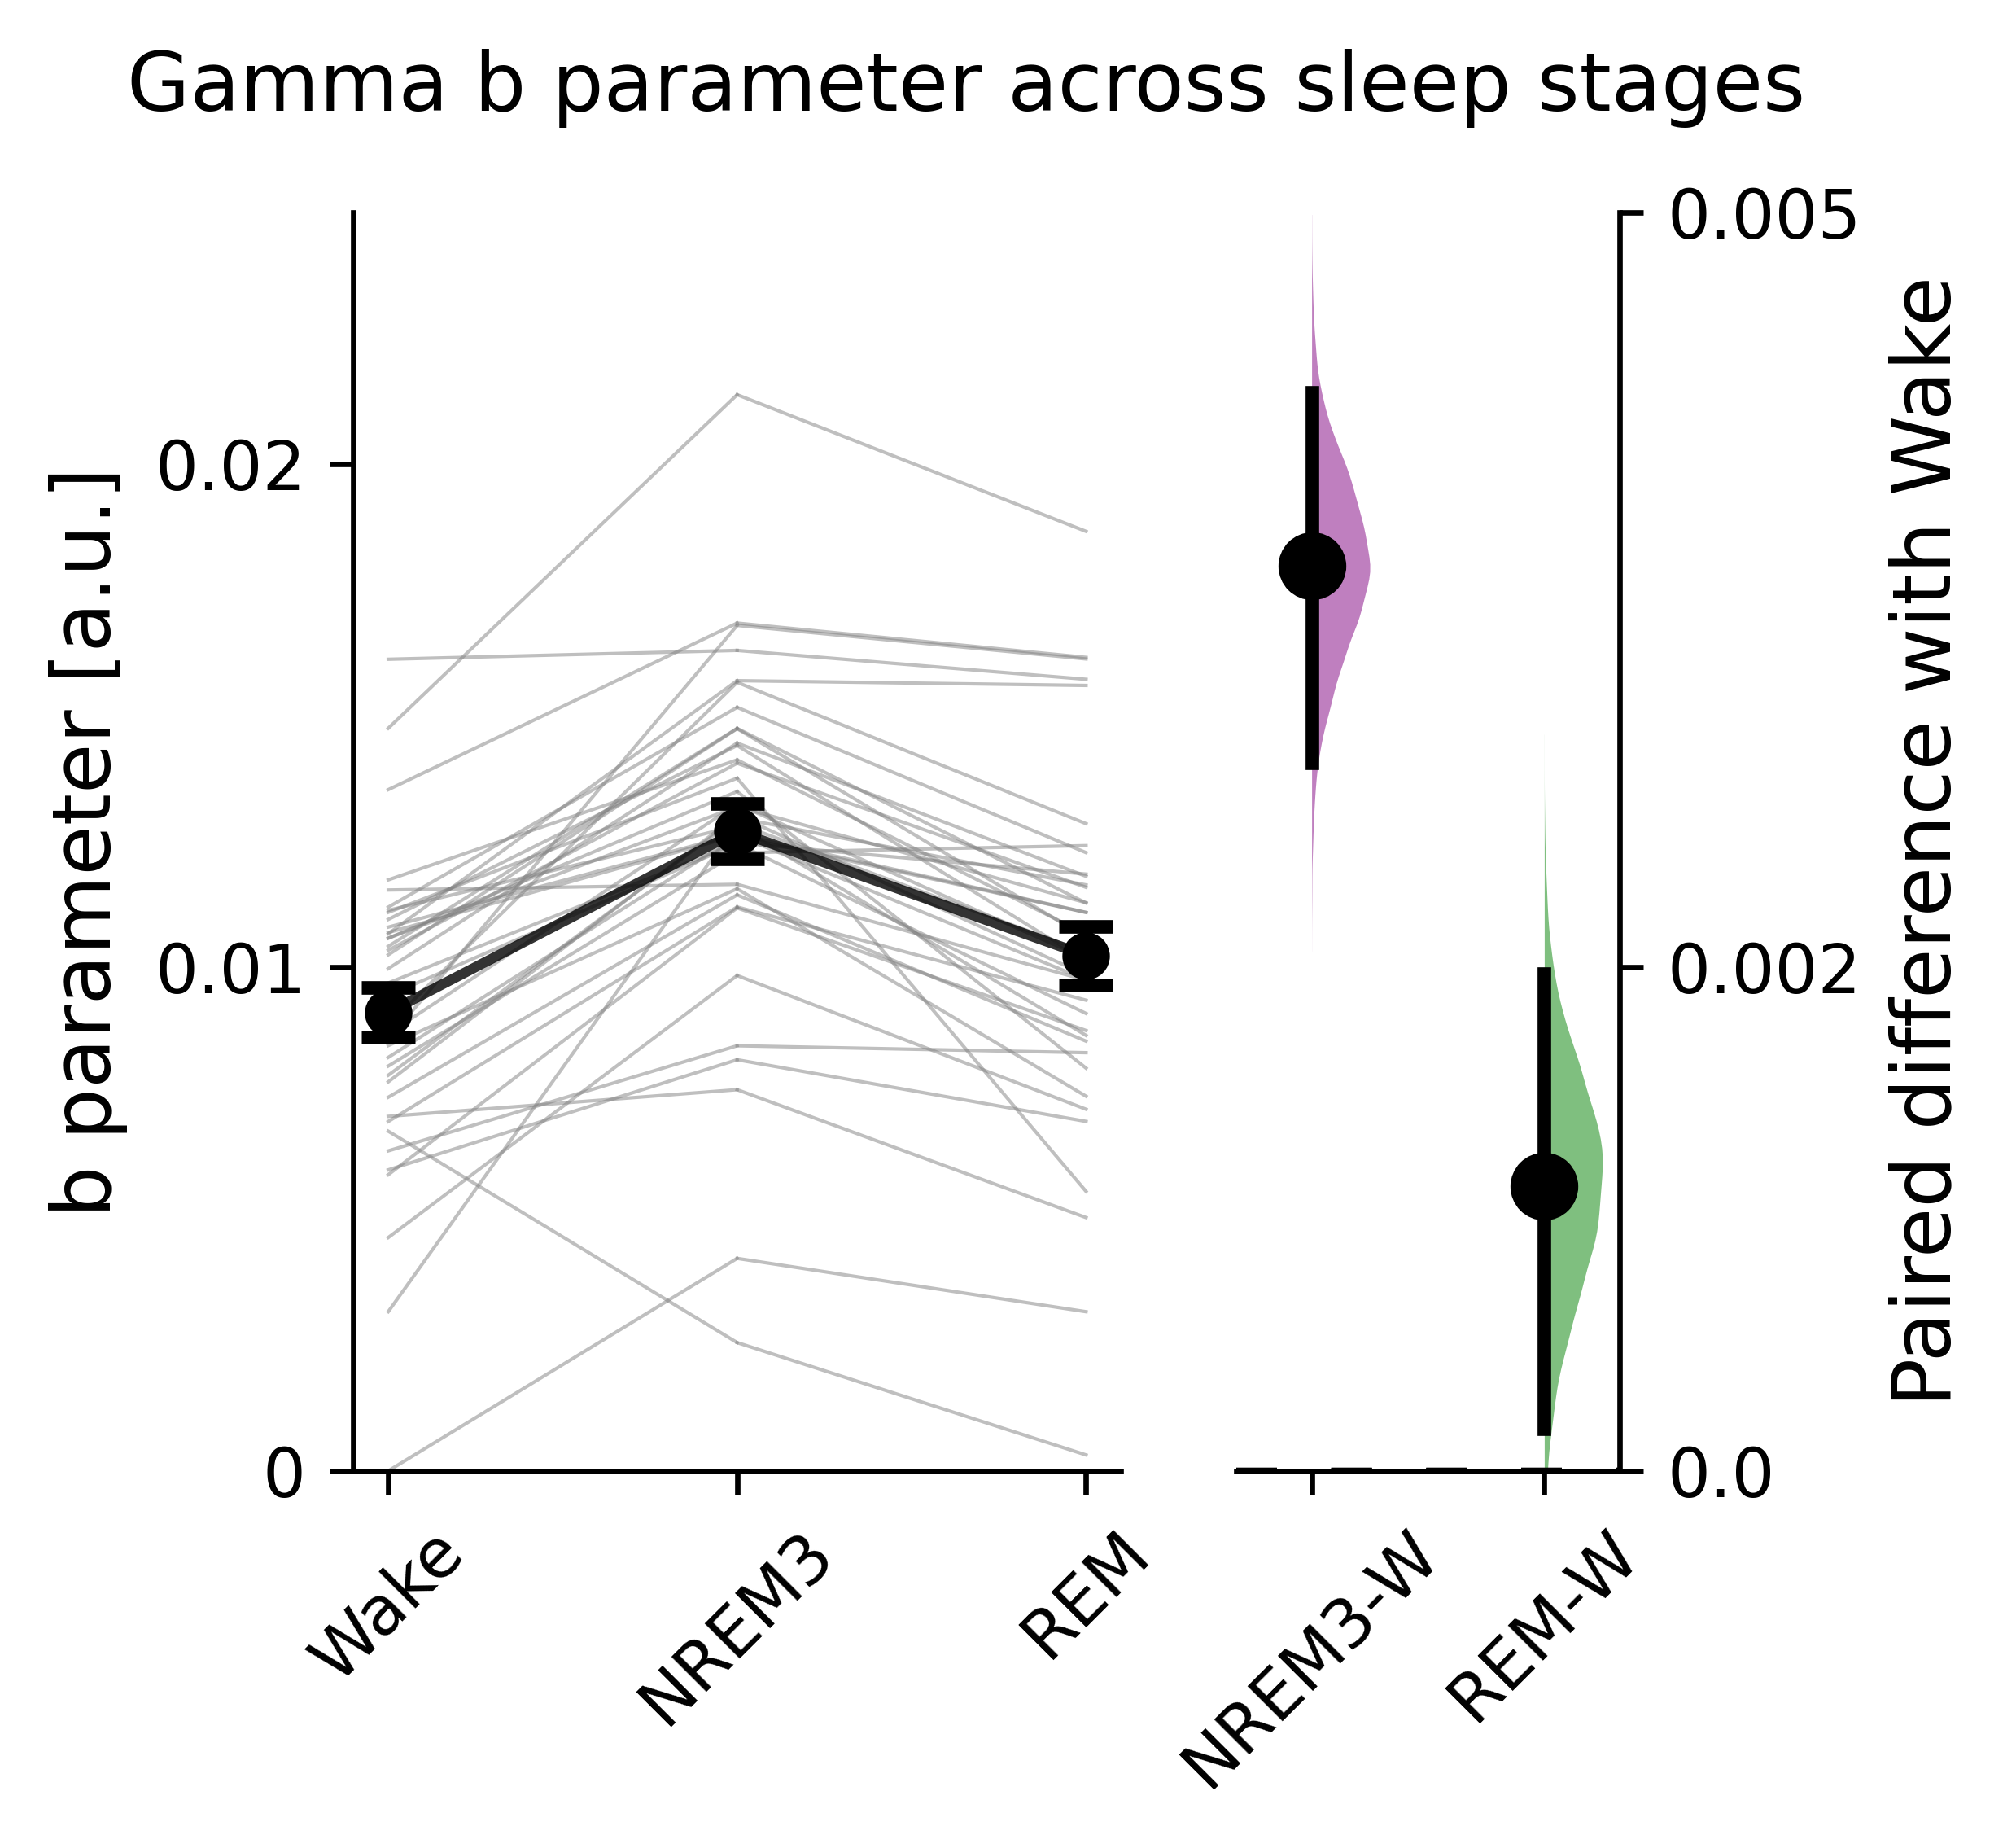

In [99]:
# Define colors for stages
stage_colors = {"W": "red", "N3": "purple", "R": "green"}

# Figure
fig, axs = plt.subplots(
    1, 2, figsize=_get_figsize_inches((8.5, 8.5)), width_ratios=[2, 1], dpi=600
)

# Slope plot
df_metric_plot = df_metric[["W", "N3", "R"]].copy()
axs[0] = slope_plot(axs[0], df_metric_plot)
# Plot parameters
axs[0].set_ylabel("b parameter [a.u.]", fontsize=fsize.LABEL_SIZE)
axs[0].set_ylim(0, 0.025)
axs[0].set_yticks([0, 0.01, 0.02], labels=[0, 0.01, 0.02], fontsize=fsize.TICK_SIZE)
axs[0].set_xticks(
    [0, 1, 2],
    ["Wake", "NREM3", "REM"],
    rotation=45,
    ha="center",
    fontsize=fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)
# Plot differences
for i, stage in enumerate(["N3", "R"]):
    avg = avg_diff(df_metric_plot[stage], df_metric_plot["W"])
    pval = ttest_rel(df_metric_plot[stage], df_metric_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_metric_plot[stage], df_metric_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )

    axs[1] = half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(0, 0.005)
axs[1].set_yticks(
    [0.0, 0.002, 0.005],
    labels=[0.0, 0.002, 0.005],
    fontsize=fsize.TICK_SIZE,
)
axs[1].set_xticks(
    [0, 1], ["NREM3-W", "REM-W"], rotation=45, fontsize=fsize.TICK_SIZE
)
axs[1].spines[["top", "left"]].set_visible(False)
fig.suptitle(f"Gamma b parameter across sleep stages", fontsize=fsize.TITLE_SIZE)

# plt.subplots_adjust(wspace=0.5)
fig.savefig(fig_path.joinpath("Fig_3", f"Fig3_b_change_stages_gamma.svg"), format="svg")
plt.show()

### D) Correlation with Timescales

In [100]:
map_coords = pd.read_csv(data_path.joinpath("mnia_centroids_coords.csv"), index_col=0)

LFP:

In [101]:
# Gather all p-values to correct
df_rhos = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
df_pvals = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
rhos_boot = {stage: {} for stage in ["W", "N3", "R"]}

# Plot one figure per parameter
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau[df_tau["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos.loc[param, stage] = rho
        df_pvals.loc[param, stage] = p_corr
        rhos_boot[stage][param] = uti.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )


# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals.to_numpy().ravel())
df_pvals_corr = pd.DataFrame(
    pvals_corr.reshape(df_pvals.shape), index=df_pvals.index, columns=df_pvals.columns
)

Stage: W, Param: k
Generating 1000 permutations...
Stage: W, Param: a
Generating 1000 permutations...
Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


In [ ]:
# TODO: adjust plot ticks

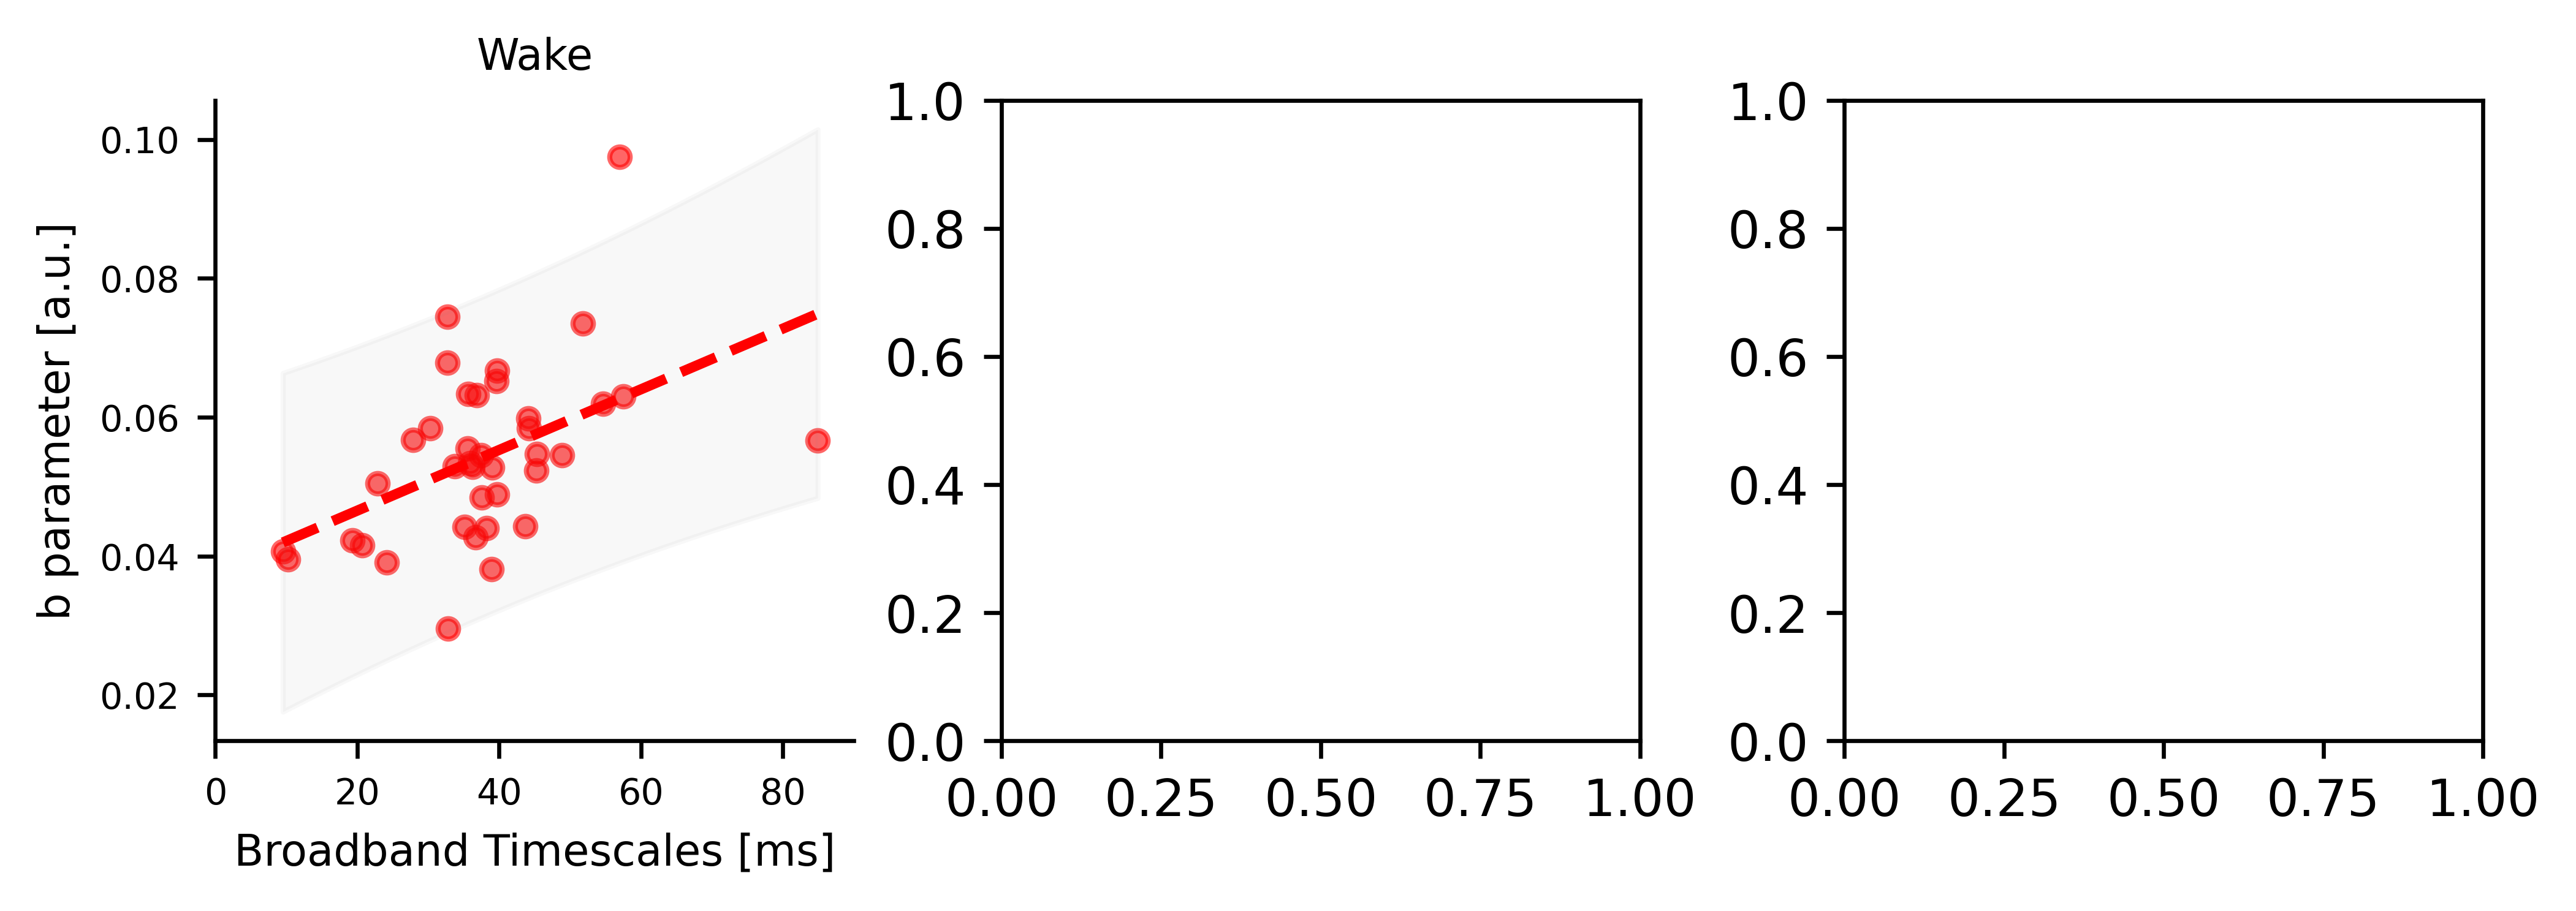

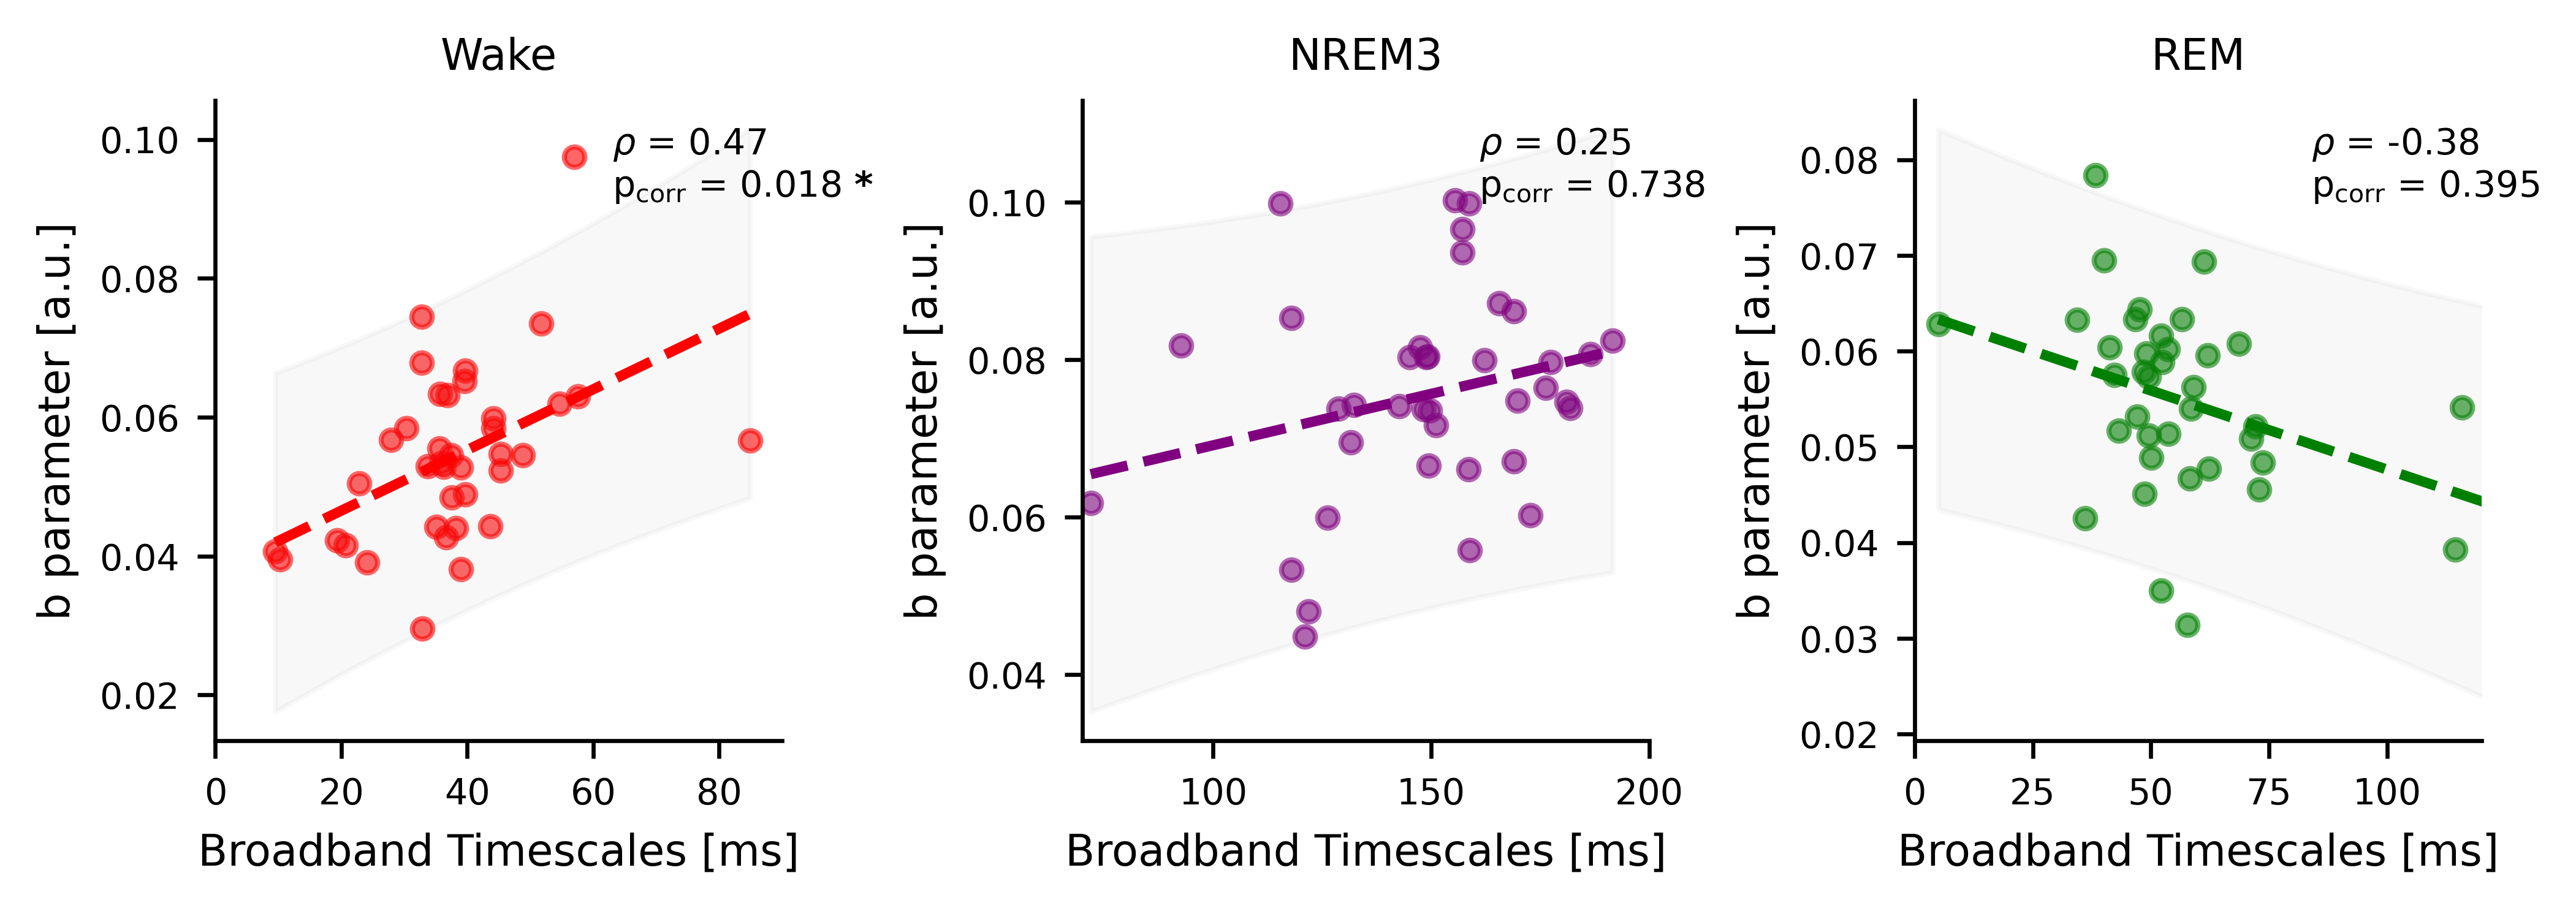

In [112]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
xlims_stages = {"W": (0, 90), "N3": (70, 200), "R": (0, 120)}
ylims_stages = {"W": (15, 40), "N3": (35, 105), "R": (15, 55)}

# # Plot one figure per parameter
# for param in ["k", "a", "b"]:

# Define figure
fig, axs = plt.subplots(1, 3, figsize=_get_figsize_inches((17.5, 6)), dpi=600, layout="constrained")
# fig.suptitle(f"Fit parameter = {param}", fontsize=15)

# One subplot per stage
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau[df_tau["stage"] == stage].copy(), method="LME"
    )

    # Get spatial parameter
    df_spa = df_sc_params_mni_stages[stage]["b"].astype(float)
    df_spa = df_spa.loc[df_tau_stage_mni.index]

    # Plot
    axs[i] = plot_corr(
        axs[i],
        df_tau_stage_mni.to_numpy().squeeze(),
        df_spa.to_numpy().squeeze(),
        df_rhos.loc[param, stage],
        df_pvals_corr.loc[param, stage],
        color=colors_stage[stage],
        title=title_dict[stage],
        xlabel="Broadband Timescales [ms]",
        ylabel=f"b parameter [a.u.]",
        xlims=xlims_stages[stage],
    )

# Save figure
save_figure(fig, fig_path.joinpath("Fig_3", f"Fig3_tau_b_corr.svg"))
# fig.savefig(fig_path.joinpath("Fig_3", f"Fig3_tau_b_corr.svg"), format="svg")
plt.show()

Gamma:

In [68]:
# Gather all p-values to correct
df_rhos_gamma = pd.DataFrame(
    index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float
)
df_pvals_gamma = pd.DataFrame(
    index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float
)
rhos_boot_gamma = {stage: {} for stage in ["W", "N3", "R"]}

# Plot one figure per parameter
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau_gamma[df_tau_gamma["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_gamma[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos_gamma.loc[param, stage] = rho
        df_pvals_gamma.loc[param, stage] = p_corr
        rhos_boot_gamma[stage][param] = uti.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )

# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals_gamma.to_numpy().ravel())
df_pvals_corr_gamma = pd.DataFrame(
    pvals_corr.reshape(df_pvals_gamma.shape),
    index=df_pvals_gamma.index,
    columns=df_pvals_gamma.columns,
)

Stage: W, Param: k
Generating 1000 permutations...
Stage: W, Param: a
Generating 1000 permutations...
Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


Stage: W, Param: k
Stage: N3, Param: k
Stage: R, Param: k


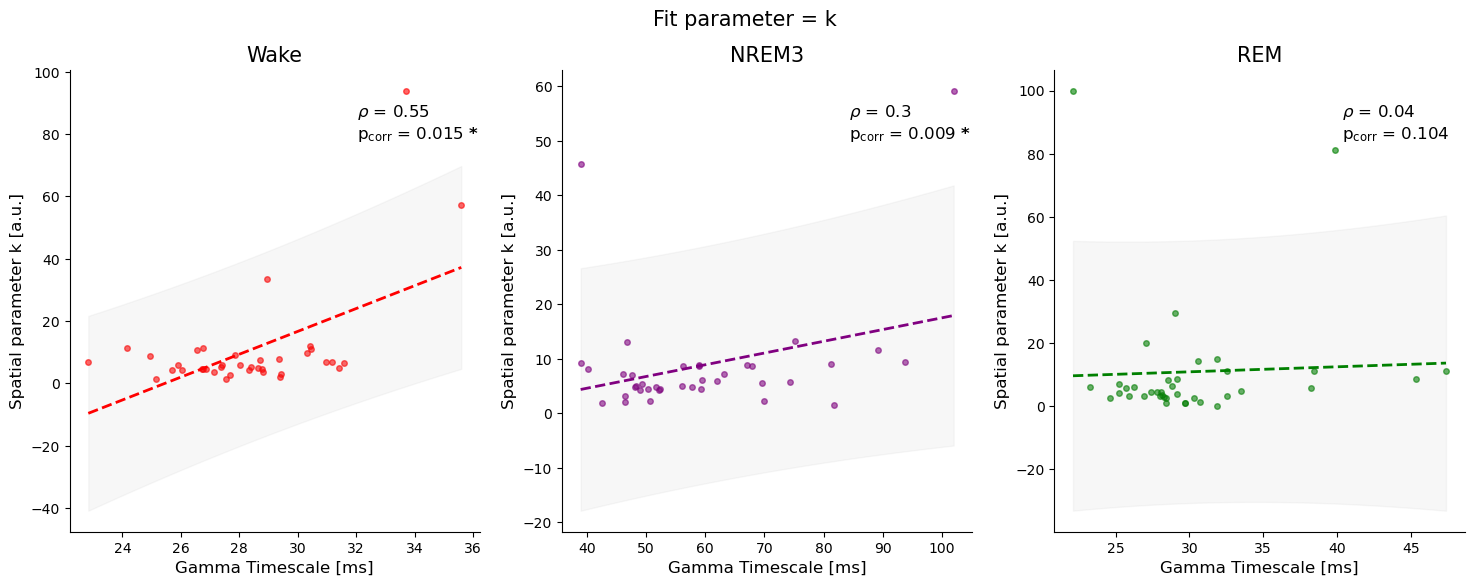

Stage: W, Param: a
Stage: N3, Param: a
Stage: R, Param: a


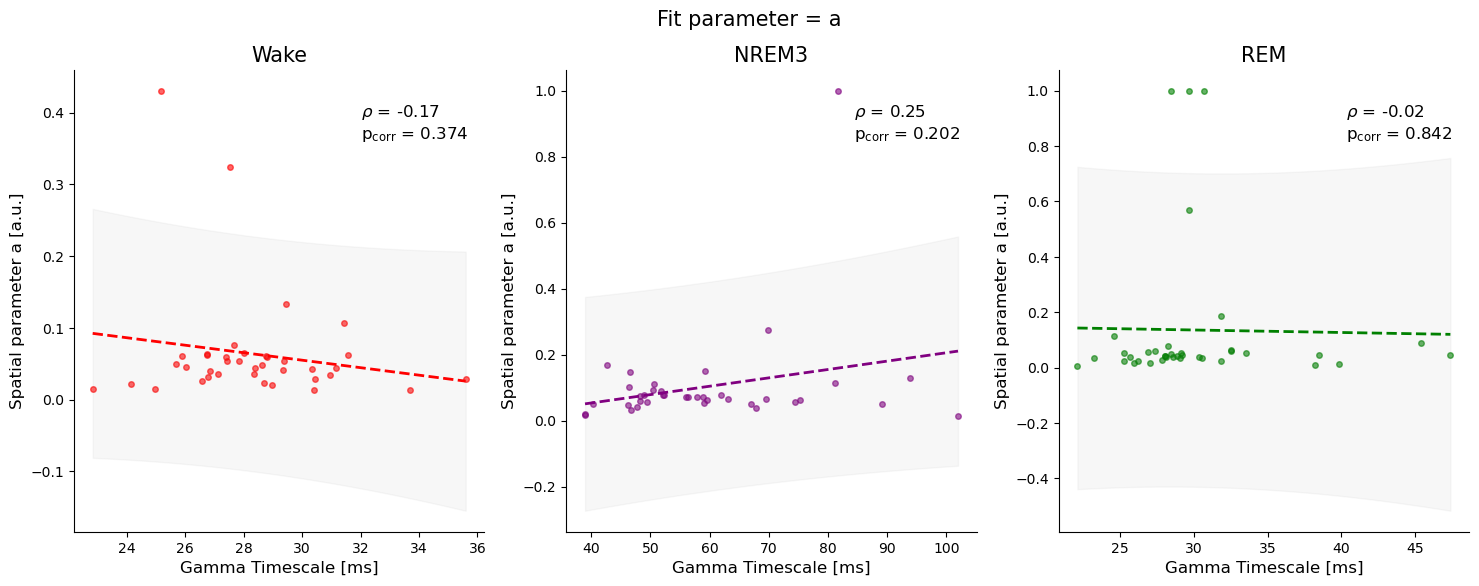

Stage: W, Param: b
Stage: N3, Param: b
Stage: R, Param: b


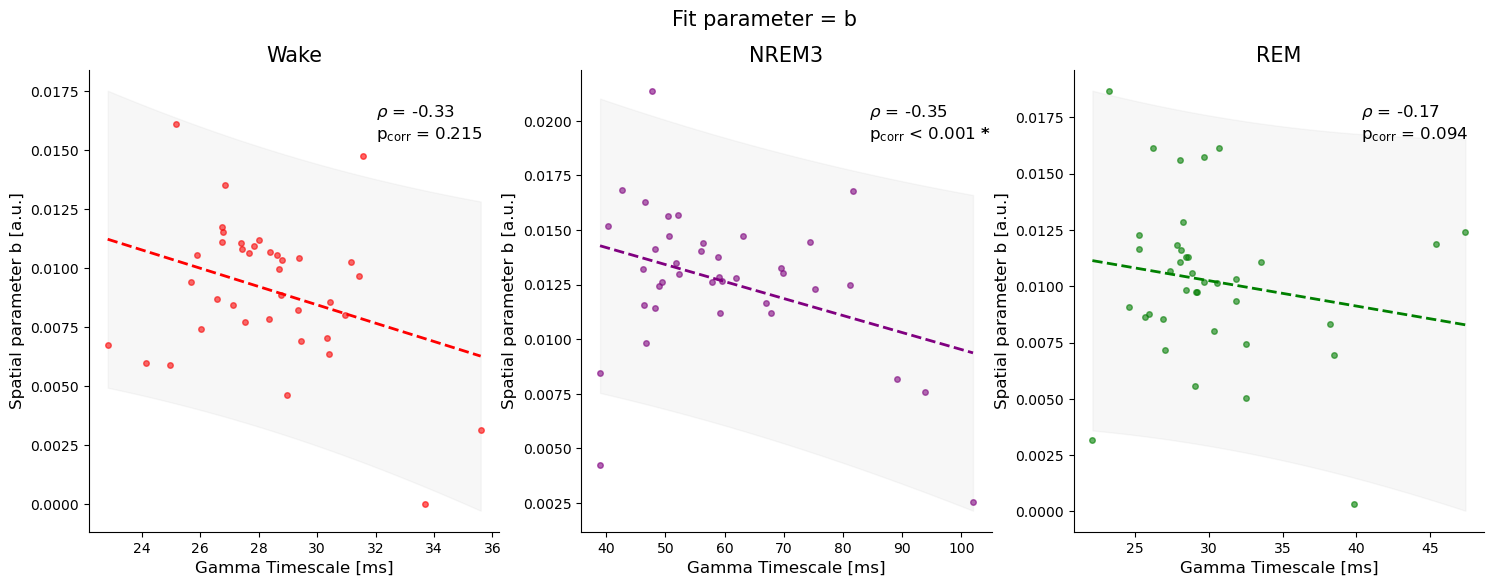

In [71]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(
            df_tau_gamma[df_tau_gamma["stage"] == stage].copy(), method="LME"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_gamma[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            df_rhos_gamma.loc[param, stage],
            df_pvals_corr_gamma.loc[param, stage],
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Gamma Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_gamma.svg"), format="svg"
    )
    plt.show()

### E) Correlation with timescales as violin plot (do not use)

LFP:

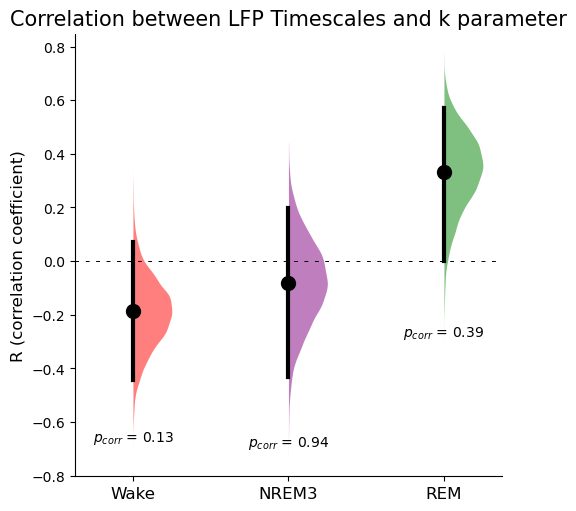

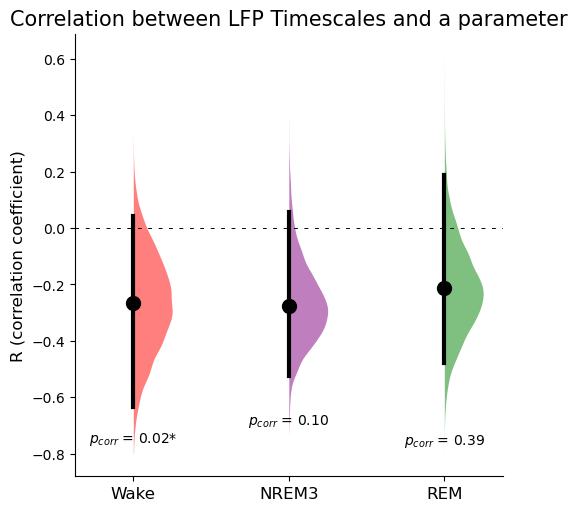

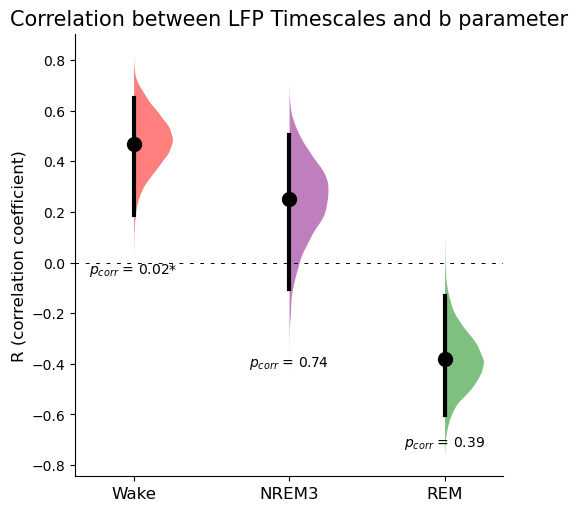

In [76]:
for param in ["k", "a", "b"]:

    fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

    for i, stage in enumerate(["W", "N3", "R"]):

        p_str = r"$p_{corr}$ "

        p_str += (
            f"= {df_pvals_corr.loc[param, stage]:.2f}"
            if df_pvals_corr.loc[param, stage] > 0.001
            else "< 0.001"
        )

        p_str += "*" if df_pvals_corr.loc[param, stage] < 0.05 else ""

        half_violin_plot(
            ax,
            df_rhos.loc[param, stage],
            x_pos=i,
            ci=list(rhos_boot[stage][param].confidence_interval),
            y_boot=rhos_boot[stage][param].bootstrap_distribution,
            color=colors_stage[stage],
            pval=p_str,
        )

    ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)

    # ax.set_ylim(-0.65, 0.3)

    # ax.set_yticks(

    #     [-0.6, -0.4, -0.2, 0.0, 0.2], labels=[-0.6, -0.4, -0.2, 0.0, 0.2], fontsize=10

    # )

    ax.set_ylabel("R (correlation coefficient)", fontsize=12)

    ax.set_title(
        f"Correlation between LFP Timescales and {param} parameter", fontsize=15
    )

    ax.spines[["top", "right"]].set_visible(False)

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_violin.svg"),
        format="svg",
        bbox_inches="tight",
    )

    plt.show()

Gamma:

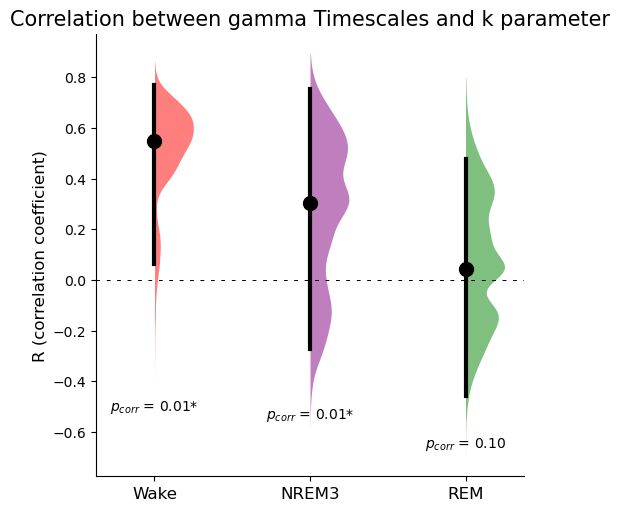

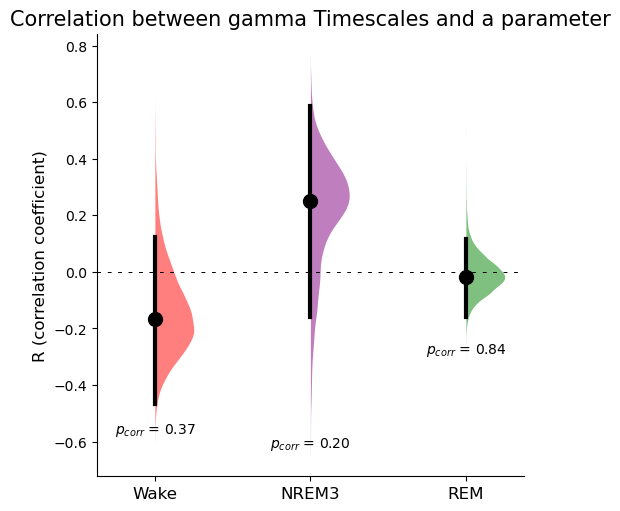

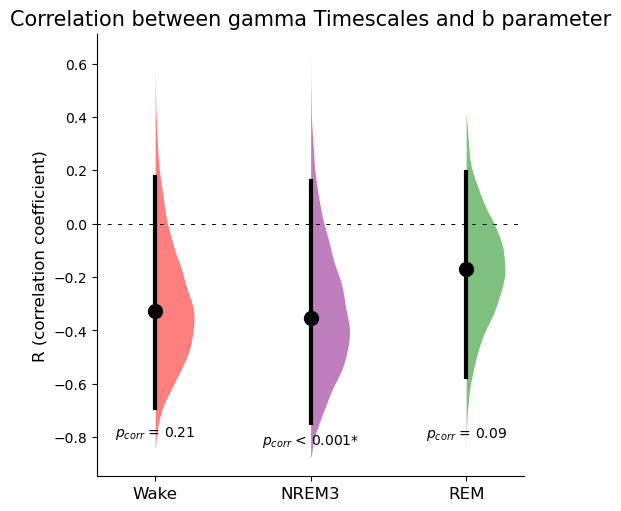

In [77]:
for param in ["k", "a", "b"]:

    fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

    for i, stage in enumerate(["W", "N3", "R"]):

        p_str = r"$p_{corr}$ "
        p_str += (
            f"= {df_pvals_corr_gamma.loc[param, stage]:.2f}"
            if df_pvals_corr_gamma.loc[param, stage] > 0.001
            else "< 0.001"
        )
        p_str += "*" if df_pvals_corr_gamma.loc[param, stage] < 0.05 else ""
        half_violin_plot(
            ax,
            df_rhos_gamma.loc[param, stage],
            x_pos=i,
            ci=list(rhos_boot_gamma[stage][param].confidence_interval),
            y_boot=rhos_boot_gamma[stage][param].bootstrap_distribution,
            color=colors_stage[stage],
            pval=p_str,
        )

    ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
    # ax.set_ylim(-0.65, 0.3)
    # ax.set_yticks(
    #     [-0.6, -0.4, -0.2, 0.0, 0.2], labels=[-0.6, -0.4, -0.2, 0.0, 0.2], fontsize=10
    # )
    ax.set_ylabel("R (correlation coefficient)", fontsize=12)
    ax.set_title(
        f"Correlation between gamma Timescales and {param} parameter", fontsize=15
    )
    ax.spines[["top", "right"]].set_visible(False)

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_violin_gamma.svg"),
        format="svg",
        bbox_inches="tight",
    )

    plt.show()